Deep Learning
=============

# Techtalk Synergic Partners - 23 Feb 2017

## Saúl Lugo

#### This notebook has been adapted from an assigment in the Introductory course to Deep Learning at www.udacity.com

In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

First reload the data we generated in `1_notmnist.ipynb`.

In [3]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  final_test_dataset = save['final_test_dataset']
  final_test_labels = save['final_test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)
  print('Final Test set', final_test_dataset.shape, final_test_labels.shape)

Training set (100000, 28, 28) (100000,)
Validation set (5000, 28, 28) (5000,)
Test set (5000, 28, 28) (5000,)
Final Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [4]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
final_test_dataset, final_test_labels = reformat(final_test_dataset, final_test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)
print('Final Test set', final_test_dataset.shape,final_test_labels.shape)

Training set (100000, 784) (100000, 10)
Validation set (5000, 784) (5000, 10)
Test set (5000, 784) (5000, 10)
Final Test set (10000, 784) (10000, 10)


In [5]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

# Neuronal Network Model With L2 Regularization

In [6]:
#First lets define a fucntion to represent the topology of our Neuronal Network:
#Topology: Multilayer Perceptron, 1 hidden layer with 1024 neurons and RELU activation function.

def mlp(x, weights, biases,l2=0):
    '''
    x: tf array with the training examples
    weights: dictionary with the tensors containing the weights for each layer
    biases: dictionary with the tensors containing the biases for each layer
    '''
    if(l2==0):
        #h1 layer z = XW + b
        h1_layer = tf.add(tf.matmul(x,weights['h1']), biases['b1'])
        #h1 layer activation function relu(z)
        h1_layer = tf.nn.relu(h1_layer)
        #output layer (no activation needed after output layer)
        out_layer = tf.add(tf.matmul(h1_layer,weights['out']), biases['out'])
    else:
        #h1 layer z = XW + b
        h1_layer = tf.add(tf.matmul(x,weights['h1']), biases['b1'])
        #h1 layer activation function relu(z)
        h1_layer = tf.nn.relu(h1_layer)
        #output layer (no activation needed after output layer)
        out_layer = tf.add(tf.matmul(h1_layer,weights['out']), biases['out'])
        out_layer = tf.add(out_layer,l2*tf.nn.l2_loss(weights['h1']))
        out_layer = tf.add(out_layer,l2*tf.nn.l2_loss(weights['out']))
    
    #we return the values predicted by the network in the output layer
    return out_layer

In [7]:
#hyper-parameters

batch_size = 128
training_epochs = 3001
learning_rate = 0.5
display_step = 500
n_hidden_1 = 1024
n_imput = image_size * image_size
n_classes = num_labels
l2 = 0.0001

#Neuronal network definitio as a TF Graph
graph = tf.Graph()
with graph.as_default():
    
    #graph imputs
    tf_train_dataset = tf.placeholder(tf.float32, shape = (batch_size, n_imput))
    tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size, n_classes))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    #graph variables
    weights = {
        'h1': tf.Variable(tf.truncated_normal([n_imput, n_hidden_1])),
        'out': tf.Variable(tf.truncated_normal([n_hidden_1,n_classes]))
    }
    
    biases = {
        'b1': tf.Variable(tf.zeros([n_hidden_1])),
        'out': tf.Variable(tf.zeros([n_classes]))
    }
    
    #Network Topology: Fully connected 1 hidden 1024 neurons, relu activation function.
    
    net_out = mlp(tf_train_dataset, weights, biases,l2)
    
    #now we define the cost (loss) function
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(net_out,tf_train_labels))
    
    
    
    #new we define out optimizer
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    
    #now we define the prediction operations for training, validation and test data.
    train_prediction = tf.nn.softmax(net_out)
    valid_prediction = tf.nn.softmax(mlp(tf_valid_dataset,weights,biases,l2))
    test_prediction = tf.nn.softmax(mlp(tf_test_dataset,weights,biases,l2))
    

Graph Variables Initialized!
Minibatch loss at step 0: 411.915039062
Minibatch accuracy: 7.03125
Validation accuracy: 24.24
Minibatch loss at step 500: 15.6833934784
Minibatch accuracy: 80.46875
Validation accuracy: 80.9
Minibatch loss at step 1000: 10.4664525986
Minibatch accuracy: 82.8125
Validation accuracy: 81.12
Minibatch loss at step 1500: 13.6425762177
Minibatch accuracy: 85.15625
Validation accuracy: 80.2
Minibatch loss at step 2000: 6.61259174347
Minibatch accuracy: 84.375
Validation accuracy: 82.28
Minibatch loss at step 2500: 5.10856151581
Minibatch accuracy: 89.0625
Validation accuracy: 81.94
Minibatch loss at step 3000: 1.25070548058
Minibatch accuracy: 85.9375
Validation accuracy: 82.48
Test accuracy: 88.94


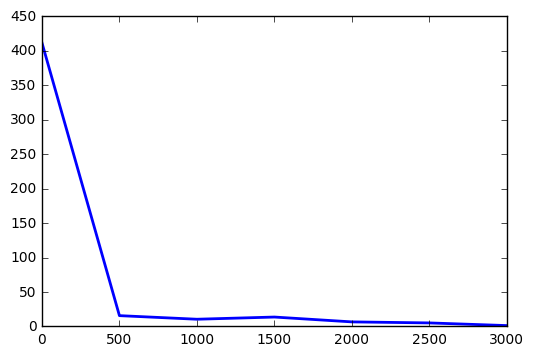

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt

#let't store the cost at each epoch in order to plot it at the end

mycost = []
epoch = []

#we compute the graph now!

with tf.Session(graph=graph) as session:
    #initializing the graph variables
    tf.initialize_all_variables().run()
    print("Graph Variables Initialized!")
    
    for step in range(training_epochs):
        #calculate the offset for the mini-batch
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        
        #generate the mini-batch
        batch_data = train_dataset[offset:(offset+batch_size), :]
        batch_labels = train_labels[offset:(offset+batch_size), :]
        
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        
        #running the graph with the mini-batch data as the training dataset
        dummy, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        
        
        #printing partial results each display_steps times
        if(step % display_step == 0):
            mycost.append(l)
            epoch.append(step)
            print("Minibatch loss at step {}: {}".format(step,l))
            print("Minibatch accuracy: {}".format(accuracy(predictions,batch_labels)))
            print("Validation accuracy: {}".format(accuracy(valid_prediction.eval(), valid_labels)))
    print("Test accuracy: {}".format(accuracy(test_prediction.eval(),test_labels)))
    
    plt.plot(epoch,mycost,linewidth=2)

---
Proposed Exercise
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---
